# Fraud detection (Prelim analysis)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
from functools import reduce

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import count_distinct, col


In [2]:
sp = SparkSession.builder.appName("Fraud detection").getOrCreate()

22/10/01 07:54:39 WARN Utils: Your hostname, Harshitas-MacBook-Air-8.local resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en0)
22/10/01 07:54:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/01 07:54:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/01 07:54:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
sp

In [4]:
def merge_folder(trans_group: str):
    """
    Function to merge everything within yellow or green or fhvhv
    """
    dir = "../data/tables/" + trans_group +"/"
    folder_locs = os.listdir(dir)

    group_list = []
    for folder in folder_locs:
        path = dir + "/" + folder
        if os.path.isdir(path):
            # print("At current path", path)
            group_list.append(sp.read.parquet(path))

    return reduce(DataFrame.unionAll, group_list)

In [5]:
dir = "../data/tables/"
groups = ["transactions_20210228_20210827_snapshot/", "transactions_20210828_20220227_snapshot/", "transactions_20220228_20220828_snapshot/"]

final_list = []
for g in groups:
    print("Started group: ", g)
    final_list.append(sp.read.parquet(dir + g))

transactions = reduce(DataFrame.unionAll, final_list)

Started group:  transactions_20210228_20210827_snapshot/


Started group:  transactions_20210828_20220227_snapshot/
Started group:  transactions_20220228_20220828_snapshot/


In [6]:
transactions.count()

14195505

In [7]:
# To make it faster to visualize
sample = transactions.sample(0.01)
sample.show(5)
sample.count()

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18496| 33651513345| 190.3084023499947|96f8f96a-806f-40b...|    2021-08-20|
|    285| 52959528548|120.96919168097035|da569255-c4ea-460...|    2021-08-20|
|  18857| 43186523025|54.161661131221784|ef863fb8-8366-459...|    2021-08-20|
|  18858| 88547577701| 92.16356630641305|a41414d6-31ed-427...|    2021-08-20|
|    444| 36555094223| 87.05948799844549|34dd604d-7d33-40a...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 5 rows



142159

In [8]:
cFraud = sp.read.option("header", True).csv("../data/tables/consumer_fraud_probability.csv")
cFraud.show(3)
cFraud.count()

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19| 97.6298077657765|
|  21419|    2021-12-10|99.24738020302328|
|   5606|    2021-10-17|84.05825045251777|
+-------+--------------+-----------------+
only showing top 3 rows



34864

In [9]:
mFraud = sp.read.option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
mFraud.show(3)
mFraud.count()

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
| 31334588839|    2021-10-02| 42.75530083865367|
| 19492220327|    2021-12-22|38.867790051131095|
+------------+--------------+------------------+
only showing top 3 rows



114

In [10]:
customer_fraud = pd.read_csv("../data/tables/consumer_fraud_probability.csv")
customer_fraud.head()

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425


In [11]:
sample.select("user_id").distinct().count()

24029

In [12]:
customer_fraud.count()

user_id              34864
order_datetime       34864
fraud_probability    34864
dtype: int64

In [13]:
merchant_fraud = pd.read_csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud.head()

,merchant_abn,order_datetime,fraud_probability
0,19492220327,2021-11-28,44.403659
1,31334588839,2021-10-02,42.755301
2,19492220327,2021-12-22,38.867790
3,82999039227,2021-12-19,94.134700
4,90918180829,2021-09-02,43.325517


In [14]:
merchant_fraud.count()

merchant_abn         114
order_datetime       114
fraud_probability    114
dtype: int64

In [15]:
transactions.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)



In [16]:
joined = cFraud.join(transactions, 
                    ["user_id", "order_datetime"])

In [17]:
joined.count()

80560

In [18]:
pie_chart = joined.groupBy("user_id").count().withColumnRenamed("count", "Num Trans").groupBy("Num Trans").count().toPandas()

In [19]:
pie_chart.sort_values(by='Num Trans', inplace=True)

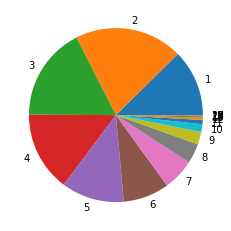

In [20]:
plt.pie(x=pie_chart["count"], labels=pie_chart["Num Trans"])
plt.show()

In [21]:
cFraud.select(count_distinct('order_datetime')).show()

+------------------------------+
|count(DISTINCT order_datetime)|
+------------------------------+
|                           365|
+------------------------------+



# Transactions with unidentified merchants

In [22]:
merch = sp.read.parquet("../data/tables/tbl_merchants.parquet")
merch.printSchema()

root
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- merchant_abn: long (nullable = true)



In [23]:
print("Distinct merchants in the merchand fraud data:")
mFraud.select(count_distinct('merchant_abn')).show()

print("Distinct merchants in the transactions data:")
transactions.select(count_distinct('merchant_abn')).show()

print("Distinct merchants in merchant table:")
merch.select(count_distinct('merchant_abn')).show()

Distinct merchants in the merchand fraud data:
+----------------------------+
|count(DISTINCT merchant_abn)|
+----------------------------+
|                          61|
+----------------------------+

Distinct merchants in the transactions data:


+----------------------------+
|count(DISTINCT merchant_abn)|
+----------------------------+
|                        4422|
+----------------------------+

Distinct merchants in merchant table:
+----------------------------+
|count(DISTINCT merchant_abn)|
+----------------------------+
|                        4026|
+----------------------------+



In [24]:
diff = transactions.select(col('merchant_abn')).subtract(merch.select(col('merchant_abn')))
diff.count()

396

In [25]:
type(diff)

pyspark.sql.dataframe.DataFrame

In [28]:
diff_list = diff.rdd.map(lambda x: x.merchant_abn).collect()
diff_df = transactions[transactions.merchant_abn.isin(diff_list)]

In [30]:
# transactions with unidentified merchants
diff_df.show(3)

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|      8| 29566626791| 74.15732460440282|71a81652-cc91-4bf...|    2021-08-20|
|  18490| 32234779638|107.14809429376949|20149572-a55b-41f...|    2021-08-20|
|     20| 67202032418| 55.46394975814555|a29071b4-29b3-4f2...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 3 rows



In [32]:
merch.filter(col("merchant_abn") == "29566626791").show(truncate=False)

+----+----+------------+
|name|tags|merchant_abn|
+----+----+------------+
+----+----+------------+

